In [1]:
import os 
import pandas as pd
import glob

In [2]:
#Pandas Settings
pd.set_option('display.max_columns', None)

## Creating the Dataset

In [3]:
path = r"C:\Users\sbsro\Documents\ML_Projects\Baseball Player Analysis"
os.chdir(path)

In [4]:
csv_files = glob.glob(os.path.join(path, "*.csv"))

In [116]:
# Get player names
players = []
for file in csv_files:
    x = file.split('\\')
    y = x[6].split('.')[0]
    players.append(y)
players

['Alonso',
 'Arozarena',
 'Arraez',
 'Devers',
 'DJ',
 'Drury',
 'Eloy',
 'Goldschmidt',
 'Harper',
 'HSK',
 'Joc Ped',
 'Jose Ramirez',
 'JROD',
 'Judge',
 'Kris Bryant',
 'Lindor',
 'Luis Urias',
 'Manny Machado',
 'Mcneill',
 'Mookie',
 'Ohtani',
 'Ronald',
 'Segura',
 'Stanton',
 'Trea',
 'Trout',
 'Verdugo',
 'Vladimir Jr',
 'Votto',
 'Xander',
 'Yelich',
 'Yordan']

In [117]:
# Create dictionary for datafiles
player_data = {}
for player in players:
    data = pd.read_csv(player + '.csv')
    player_data[player] = pd.DataFrame(data)

In [118]:
for player in players:
    print(player_data[player].isna().sum())

Year               0
Age                0
Tm                 0
Lg                 0
G                  0
PA                 0
AB                 0
R                  0
H                  0
2B                 0
3B                 0
HR                 0
RBI                0
SB                 0
CS                 0
BB                 0
SO                 0
BA                 0
OBP                0
SLG                0
OPS                0
OPS+               0
TB                 0
GDP                0
HBP                0
SH                 0
SF                 0
IBB                0
Pos                2
Awards             4
Year-additional    1
dtype: int64
Year               0
Age                0
Tm                 0
Lg                 0
G                  0
PA                 0
AB                 0
R                  0
H                  0
2B                 0
3B                 0
HR                 0
RBI                0
SB                 0
CS                 0
BB                 0


## Data Preprocessing

In [119]:
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [120]:
class Preprocessing():
    def __init__(self):
        pass
        
    
    def Drop(self,data):
        # Drop columns
        data.drop(columns = ['Pos', 'Awards', 'Year-additional', 'Lg'], inplace = True)
        data.drop(data.tail(2).index, inplace = True)
        data.dropna(inplace= True)
        return data
    
    def Encode(self,data):
        # Ordinal encoding the teams, there are too many to OneHotEncode
        teams = ['BAL', 'TBR', 'TOR', 'BOS', 'NYY', 'MIN', 'CLE', 'DET', 'CHW', 'KCR', 'TEX', 'HOU','SEA',
                'LAA', 'OAK', 'ATL', 'PHI', 'MIA', 'NYM', 'WSN', 'MIL', 'CHC', 'CIN', 'PIT', 'STL', 'LAD',
                'SFG', 'ARI', 'SDP', 'COL', 'TOT', 'FLA']
        ordinal_encoder = OrdinalEncoder(categories=[teams])
        data['Tm'] = ordinal_encoder.fit_transform(data[['Tm']])
        return data
    
    def new_features(self,data):
        data['HR/AB'] = data.HR/data.AB
        data['AB/PA'] = data.AB/data.PA
        data['PA/G'] = data.PA/data.G
        return data
    # Issue with this function is that for players with two years or less of data will have 1 and -1 values 
    # There is also no standard scale across all dataframes 
    def normalize(self,data):
        # Normalize Numerical Values
        columns_to_exclude = ['Tm', 'Lg']
        data_filtered = data.drop(columns = columns_to_exclude)
        scaler = StandardScaler()
        norm_values = scaler.fit_transform(data_filtered)
        norm_data = pd.DataFrame(norm_values, columns=data_filtered.columns)
        
        # Add missing columns
        for column in data.columns:
            if column not in data_filtered.columns:
                norm_data[column] = data[column]
        return norm_data
    
    def preprocess(self,data):
        dropped_data = self.Drop(data.copy())
        new_features_data = self.new_features(dropped_data.copy())
        #norm_data = self.normalize(dropped_data.copy())
        preprocessed_data = self.Encode(new_features_data.copy())
        return preprocessed_data

In [121]:
# Will scale all numerical data of each dataset with the same scale for all
class Scaling():
    def __init__(self, columns_to_normalize):
        self.columns_to_normalize = columns_to_normalize
        self.scaler = MinMaxScaler()
        
    def fit(self, reference_data):
        self.scaler.fit(reference_data[self.columns_to_normalize])
    
    def transform(self, data):
        data[self.columns_to_normalize] = self.scaler.transform(data[self.columns_to_normalize])
        return data
    
    def denormalize(self, data):
        denormalized_data = data.copy()
        denormalized_data[self.columns_to_normalize] = self.scaler.inverse_transform(denormalized_data[self.columns_to_normalize])
        return denormalized_data

In [122]:
preprocessor = Preprocessing()
for player in players:
    player_data[player] = preprocessor.preprocess(player_data[player])
    print('{}: Done'.format(player))

Alonso: Done
Arozarena: Done
Arraez: Done
Devers: Done
DJ: Done
Drury: Done
Eloy: Done
Goldschmidt: Done
Harper: Done
HSK: Done
Joc Ped: Done
Jose Ramirez: Done
JROD: Done
Judge: Done
Kris Bryant: Done
Lindor: Done
Luis Urias: Done
Manny Machado: Done
Mcneill: Done
Mookie: Done
Ohtani: Done
Ronald: Done
Segura: Done
Stanton: Done
Trea: Done
Trout: Done
Verdugo: Done
Vladimir Jr: Done
Votto: Done
Xander: Done
Yelich: Done
Yordan: Done


In [123]:
columns_norm = set(list(player_data[players[0]].columns)) - set(['Tm', 'League_NL', 'League_AL', 'League_MLB', 'BA', 'OBP', 
                                                                 'SLG', 'OPS', 'TB'])
scaler = Scaling(columns_to_normalize=list(columns_norm))
scaler.fit(player_data[players[0]])

In [124]:
for player in players:
    player_data[player] = scaler.transform(player_data[player])

In [125]:
scaler.denormalize(player_data[players[1]])

,Year,Age,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,HR/AB,AB/PA,PA/G
0,2019.0,24.0,24.0,19.0,23.0,20.0,4.0,6.0,1.0,0.0,1.0,2.0,2.0,1.0,2.0,4.0,0.300,0.391,0.500,0.891,135.0,10,0.0,1.0,0.0,0.0,0.0,0.050000,0.869565,1.210526
1,2020.0,25.0,1.0,23.0,76.0,64.0,15.0,18.0,2.0,0.0,7.0,11.0,4.0,0.0,6.0,22.0,0.281,0.382,0.641,1.022,182.0,41,2.0,5.0,0.0,1.0,0.0,0.109375,0.842105,3.304348
2,2021.0,26.0,1.0,141.0,604.0,529.0,94.0,145.0,32.0,3.0,20.0,69.0,20.0,10.0,56.0,170.0,0.274,0.356,0.459,0.815,129.0,243,9.0,14.0,0.0,5.0,4.0,0.037807,0.875828,4.283688
3,2022.0,27.0,1.0,153.0,645.0,586.0,72.0,154.0,41.0,3.0,20.0,89.0,32.0,12.0,46.0,156.0,0.263,0.327,0.445,0.773,123.0,261,17.0,11.0,0.0,2.0,2.0,0.034130,0.908527,4.215686
4,2023.0,28.0,1.0,128.0,553.0,463.0,85.0,121.0,14.0,2.0,21.0,76.0,20.0,10.0,68.0,130.0,0.261,0.373,0.436,0.809,125.0,202,7.0,17.0,0.0,5.0,0.0,0.045356,0.837251,4.320312


In [91]:
import seaborn as sn

<Axes: >

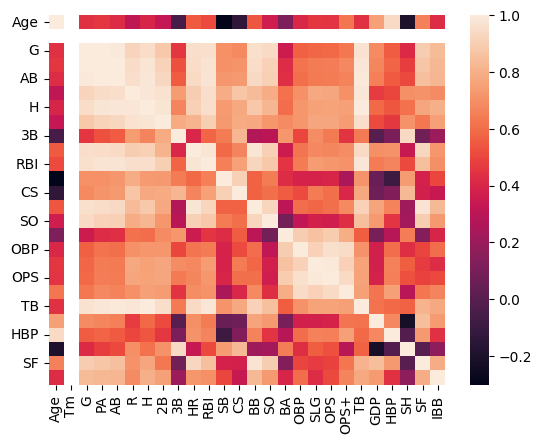

In [92]:
numerical_df = player_data[players[3]].drop(columns = ['Year'])
corr_mat1 = numerical_df.corr()
sn.heatmap(corr_mat1)

In [93]:
from sklearn.model_selection import train_test_split

In [94]:
player_data[players[2]]

,Year,Age,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB
0,0.00,-0.50,5.0,0.336538,0.279736,0.303342,0.319444,0.535088,0.583333,0.333333,-0.324324,-0.072917,0.25,2.0,0.250000,-0.262295,0.334,0.399,0.439,0.838,0.08,143,-0.1250,-0.333333,0.0,0.250,-0.153846
1,0.25,-0.25,5.0,-0.240385,-0.259912,-0.246787,-0.208333,-0.105263,0.125000,0.000000,-0.432432,-0.229167,-0.25,0.0,-0.333333,-0.409836,0.321,0.364,0.402,0.765,-0.36,45,-0.1250,-0.400000,0.0,0.000,-0.230769
2,0.50,0.00,5.0,0.615385,0.528634,0.565553,0.375000,0.684211,0.458333,2.000000,-0.378378,0.072917,0.25,2.0,0.395833,-0.106557,0.294,0.357,0.376,0.733,-0.68,161,0.3125,-0.266667,0.0,0.625,-0.076923
3,0.75,0.25,5.0,0.836538,0.801762,0.871465,0.791667,1.096491,1.041667,0.333333,-0.216216,0.145833,0.75,4.0,0.541667,-0.147541,0.316,0.375,0.420,0.795,0.20,230,0.1250,-0.200000,0.0,0.250,-0.076923
4,1.00,0.50,17.0,0.663462,0.645374,0.730077,0.333333,1.087719,0.875000,1.000000,-0.297297,0.239583,0.25,2.0,0.166667,-0.245902,0.350,0.392,0.447,0.839,0.32,220,0.6875,-0.133333,1.0,0.250,0.384615


In [126]:
# Create the testing data
testing_year = {}
columns_to_drop = ['League_AL', 'League_NL', 'League_MLB']
for player in players:
    testing_year[player] = player_data[player].tail(1).drop(columns = ['Year', 'Age', 'Tm', 'BA', 'OBP', 
                                                                 'SLG', 'OPS', 'TB', 'HR/AB', 'AB/PA', 
                                                                    'PA/G'])
    column_to_keep = [col for col in testing_year[player].columns if col not in columns_to_drop]
    testing_year[player] = testing_year[player][column_to_keep]

new_test_year = {key: value.values for key, value in testing_year.items()}

In [127]:
train_years = {}
for player in players:
    train_years[player] = player_data[player].drop(player_data[player].tail(1).index)
new_train_years = {key: value.values for key, value in train_years.items()}

## Model Training

In [128]:
input_shape = new_train_years[players[2]].shape[1]
output_shape = new_test_year[players[2]].shape[1]

In [129]:
print('Output Shape: {}'.format(output_shape))
print('Input Shape: {}'.format(input_shape))

Output Shape: 19
Input Shape: 30


In [130]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [131]:
max_seq_len = 20
x_padded = {}
for player in players:
    x_padded[player] = np.pad(new_train_years[player], ((0, max_seq_len - new_train_years[player].shape[0]), (0,0)),
                     mode = 'constant')

In [132]:
# I want to prioritize accuracy in Batting Average, Hits and Home Runs:
def custom_loss(y_true, y_pred):
    weights = tf.constant([.5, 1.0, 3.5, 1.5, 3.5, 1.75 , 1.0 , 4.0, 2.0, 1.5,
                          1.5, 1.0, 1.0, 1.0, .5, .5, .5, .25, .25], dtype = tf.float32)
    squared_erros = tf.square(y_true - y_pred)
    weighted_errors = squared_erros * weights
    loss = tf.reduce_mean(weighted_errors)
    return loss

In [133]:
model = keras.Sequential([
    layers.Input(shape=(max_seq_len, input_shape)),
    layers.Masking(mask_value=0.0, input_shape = (max_seq_len, 27)),
    layers.LSTM(64),
    #layers.Dropout(.1),
    layers.Dense(output_shape)
])
model.compile(optimizer = 'adam', loss = custom_loss)

In [134]:
for player in players:
    print(player)
    model.fit(x_padded[player][np.newaxis, ...], new_test_year[player][np.newaxis, ...], epochs = 20, verbose =1)

Alonso
Epoch 1/20
1/1 [==============================] - 3s 3s/step - loss: 1.0311
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 0.9607
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.8932
Epoch 4/20
1/1 [==============================] - 0s 6ms/step - loss: 0.8286
Epoch 5/20
1/1 [==============================] - 0s 6ms/step - loss: 0.7664
Epoch 6/20
1/1 [==============================] - 0s 8ms/step - loss: 0.7067
Epoch 7/20
1/1 [==============================] - 0s 8ms/step - loss: 0.6498
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5964
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5470
Epoch 10/20
1/1 [==============================] - 0s 6ms/step - loss: 0.5023
Epoch 11/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4631
Epoch 12/20
1/1 [==============================] - 0s 8ms/step - loss: 0.4240
Epoch 13/20
1/1 [==============================] - 0s 7ms/step - lo

1/1 [==============================] - 0s 7ms/step - loss: 0.1730
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1405
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1159
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0984
Epoch 10/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0869
Epoch 11/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0806
Epoch 12/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0765
Epoch 13/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0691
Epoch 14/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0585
Epoch 15/20
1/1 [==============================] - 0s 8ms/step - loss: 0.0482
Epoch 16/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0396
Epoch 17/20
1/1 [==============================] - 0s 6ms/step - loss: 0.0325
Epoch 18/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0268
E

1/1 [==============================] - 0s 7ms/step - loss: 0.6226
Epoch 12/20
1/1 [==============================] - 0s 6ms/step - loss: 0.5509
Epoch 13/20
1/1 [==============================] - 0s 8ms/step - loss: 0.5138
Epoch 14/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4856
Epoch 15/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4589
Epoch 16/20
1/1 [==============================] - 0s 6ms/step - loss: 0.4326
Epoch 17/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4066
Epoch 18/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3808
Epoch 19/20
1/1 [==============================] - 0s 7ms/step - loss: 0.3548
Epoch 20/20
1/1 [==============================] - 0s 6ms/step - loss: 0.3283
Jose Ramirez
Epoch 1/20
1/1 [==============================] - 0s 8ms/step - loss: 2.1985
Epoch 2/20
1/1 [==============================] - 0s 6ms/step - loss: 2.1726
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - l

1/1 [==============================] - 0s 7ms/step - loss: 0.8109
Epoch 17/20
1/1 [==============================] - 0s 7ms/step - loss: 0.7864
Epoch 18/20
1/1 [==============================] - 0s 6ms/step - loss: 0.7630
Epoch 19/20
1/1 [==============================] - 0s 7ms/step - loss: 0.7402
Epoch 20/20
1/1 [==============================] - 0s 7ms/step - loss: 0.7178
Luis Urias
Epoch 1/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3545
Epoch 2/20
1/1 [==============================] - 0s 8ms/step - loss: 0.3081
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 0.2481
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1913
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1464
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 0.1184
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 0.0944
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 0.

1/1 [==============================] - 0s 10ms/step - loss: 15.7120
Epoch 2/20
1/1 [==============================] - 0s 7ms/step - loss: 15.6391
Epoch 3/20
1/1 [==============================] - 0s 7ms/step - loss: 15.5560
Epoch 4/20
1/1 [==============================] - 0s 7ms/step - loss: 15.4636
Epoch 5/20
1/1 [==============================] - 0s 7ms/step - loss: 15.3625
Epoch 6/20
1/1 [==============================] - 0s 7ms/step - loss: 15.2527
Epoch 7/20
1/1 [==============================] - 0s 7ms/step - loss: 15.1335
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 15.0020
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 14.8517
Epoch 10/20
1/1 [==============================] - 0s 7ms/step - loss: 14.6727
Epoch 11/20
1/1 [==============================] - 0s 7ms/step - loss: 14.4607
Epoch 12/20
1/1 [==============================] - 0s 8ms/step - loss: 14.2285
Epoch 13/20
1/1 [==============================] - 0s 7ms/step - loss: 

1/1 [==============================] - 0s 7ms/step - loss: 0.7054
Epoch 7/20
1/1 [==============================] - 0s 6ms/step - loss: 0.6871
Epoch 8/20
1/1 [==============================] - 0s 7ms/step - loss: 0.6666
Epoch 9/20
1/1 [==============================] - 0s 7ms/step - loss: 0.6445
Epoch 10/20
1/1 [==============================] - 0s 7ms/step - loss: 0.6212
Epoch 11/20
1/1 [==============================] - 0s 6ms/step - loss: 0.5970
Epoch 12/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5723
Epoch 13/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5474
Epoch 14/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5227
Epoch 15/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4984
Epoch 16/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4745
Epoch 17/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4511
Epoch 18/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4277
E

1/1 [==============================] - 0s 7ms/step - loss: 0.8569
Epoch 12/20
1/1 [==============================] - 0s 7ms/step - loss: 0.8077
Epoch 13/20
1/1 [==============================] - 0s 7ms/step - loss: 0.7529
Epoch 14/20
1/1 [==============================] - 0s 6ms/step - loss: 0.6999
Epoch 15/20
1/1 [==============================] - 0s 7ms/step - loss: 0.6544
Epoch 16/20
1/1 [==============================] - 0s 7ms/step - loss: 0.6143
Epoch 17/20
1/1 [==============================] - 0s 7ms/step - loss: 0.5771
Epoch 18/20
1/1 [==============================] - 0s 6ms/step - loss: 0.5418
Epoch 19/20
1/1 [==============================] - 0s 8ms/step - loss: 0.5080
Epoch 20/20
1/1 [==============================] - 0s 7ms/step - loss: 0.4758


In [174]:
pred = model.predict(x_padded['Xander'][np.newaxis, ...])

1/1 [==============================] - 0s 16ms/step


In [175]:
pred_df = pd.DataFrame(pred, columns=testing_year[players[0]].columns)

In [176]:
pred_df

,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,OPS+,GDP,HBP,SH,SF,IBB
0,0.804323,0.886531,0.870661,0.772409,0.704368,0.959535,0.930702,0.125214,0.365251,2.360902,1.621098,0.999762,0.106899,0.007385,0.515015,0.156188,0.433096,0.19367,0.144357


In [170]:
player_data[players[1]]

,Year,Age,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,HR/AB,AB/PA,PA/G
0,0.00,0.00,24.0,-0.365385,-0.475771,-0.483290,-0.375000,-0.368421,-0.208333,0.000000,-0.405405,-0.343750,0.25,1.0,-0.458333,-0.467213,0.300,0.391,0.500,0.891,0.52,10,-0.2500,-0.333333,0.0,-0.125,-0.230769,-0.698999,0.473726,-26.244332
1,0.25,0.25,1.0,-0.326923,-0.359031,-0.370180,-0.222222,-0.263158,-0.166667,0.000000,-0.243243,-0.250000,0.75,0.0,-0.375000,-0.319672,0.281,0.382,0.641,1.022,2.40,41,-0.1250,-0.066667,0.0,0.000,-0.230769,1.902479,-0.825220,-7.806045
2,0.50,0.50,1.0,0.807692,0.803965,0.825193,0.875000,0.850877,1.083333,1.000000,0.108108,0.354167,4.75,10.0,0.666667,0.893443,0.274,0.356,0.459,0.815,0.28,243,0.3125,0.533333,0.0,0.500,0.076923,-1.233220,0.769968,0.818068
3,0.75,0.75,1.0,0.923077,0.894273,0.971722,0.569444,0.929825,1.458333,1.000000,0.108108,0.562500,7.75,12.0,0.458333,0.778689,0.263,0.327,0.445,0.773,0.04,261,0.8125,0.333333,0.0,0.125,-0.076923,-1.394347,2.316753,0.219242
4,1.00,1.00,1.0,0.682692,0.691630,0.655527,0.750000,0.640351,0.333333,0.666667,0.135135,0.427083,4.75,10.0,0.916667,0.565574,0.261,0.373,0.436,0.809,0.12,202,0.1875,0.733333,0.0,0.500,-0.230769,-0.902457,-1.054826,1.140586


In [182]:
def prepared_pred(pred, player):
    pred_df = pd.DataFrame(pred, columns=testing_year[player].columns)
    #Insert missing columns to denormalize
    pred_df.insert(0, "Year", float(player_data[player].tail(1).Year.values), True)
    pred_df.insert(1, "Age", float(player_data[player].tail(1).Age.values), True)
    pred_df.insert(21, "HR/AB", 0, True)
    pred_df.insert(22, "AB/PA", 0, True)
    pred_df.insert(23, "PA/G", 0, True)
    
    #Denormalize and calculate other statistics
    denorm_pred = scaler.denormalize(pred_df)
    denorm_pred.insert(15, 'BA', denorm_pred.H/denorm_pred.AB, True)
    denorm_pred.insert(16, 'OBP', (denorm_pred.H + denorm_pred.BB + denorm_pred.HBP)/(denorm_pred.AB + denorm_pred.BB + 
                                                                                     denorm_pred.HBP + denorm_pred.SF), True)
    denorm_pred.insert(17, 'SLG', ((denorm_pred['H'] - denorm_pred['2B'] - denorm_pred['3B'] - denorm_pred.HR) + 2*denorm_pred['2B'] + 
                                   3*denorm_pred['3B'] + 4*denorm_pred.HR) / denorm_pred.AB, True)
    denorm_pred.insert(18, 'OPS', denorm_pred.SLG + denorm_pred.OBP, True)
    denorm_pred.insert(20, 'TB', ((denorm_pred['H'] - denorm_pred['2B'] - denorm_pred['3B'] - denorm_pred.HR) + 2*denorm_pred['2B'] + 
                                   3*denorm_pred['3B'] + 4*denorm_pred.HR), True)
    denorm_pred['HR/AB'] = denorm_pred.HR/denorm_pred.AB
    denorm_pred['AB/PA'] = denorm_pred.AB/denorm_pred.PA
    denorm_pred['PA/G'] = denorm_pred.PA/denorm_pred.G
    
    
    not_round = ['BA', 'OBP', 'SLG', 'OPS', 'HR/AB', 'AB/PA']
    for column in denorm_pred.columns:
        if column not in not_round:
            denorm_pred[column] = round(denorm_pred[column])
        else:
            denorm_pred[column] = round(denorm_pred[column], 3)
    return denorm_pred

def denorm_actual(player):
    #testing_year[player].insert(0, "Year", int(player_data[player].tail(1).Year.values), True)
    #testing_year[player].insert(1, "Age", int(player_data[player].tail(1).Age.values), True)
    
    actual = scaler.denormalize(player_data[player].tail(1))
    return actual

In [183]:
final_pred = prepared_pred(pred, 'Xander')
final_pred

,Year,Age,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,HR/AB,AB/PA,PA/G
0,2023.0,30.0,141.0,641.0,547.0,87.0,128.0,29.0,3.0,21.0,70.0,10.0,2.0,72.0,74.0,0.235,0.331,0.411,0.743,122.0,225.0,12.0,8.0,0.0,3.0,5.0,0.038,0.852,5.0


In [184]:
denorm_actual('Xander')

,Year,Age,Tm,G,PA,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,BA,OBP,SLG,OPS,OPS+,TB,GDP,HBP,SH,SF,IBB,HR/AB,AB/PA,PA/G
10,2023.0,30.0,28.0,127.0,542.0,486.0,58.0,125.0,20.0,0.0,15.0,45.0,13.0,1.0,48.0,93.0,0.257,0.328,0.391,0.719,102.0,190,19.0,5.0,0.0,3.0,0.0,0.030864,0.896679,4.267717


In [163]:
def Error(pred, act):
    predicted = pred.drop(columns = ['Year', 'Age']).values.reshape((-1,))
    
    actual = act.drop(columns = ['Year', 'Age', 'Tm']).values.reshape((-1,))
    actual = np.array([1 if value == 0 else value for value in actual])
    
    percent_errors = np.abs((actual - predicted)/actual) *100
    mean_pe = np.mean(percent_errors)
    print('Mean Percent Error: {}%'.format(round(mean_pe,4)))

In [165]:
Error(final_pred, denorm_actual('HSK'))

Mean Percent Error: 41.6554%


In [303]:
player_data['Ronald'].tail(1).Age.values

array([0.75])

In [81]:
denorm_actual

7    1.75
Name: Age, dtype: float64